# Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install folium

In [3]:
root_path = '/content/drive/My Drive/Case Studies/Taxi Demand'  #change dir to your project folder

In [4]:
import os
os.chdir(root_path)  #change dir

In [5]:
!dir

GCP-Coupons-Instructions.rtf  test.csv	 train.csv.zip
sample_submission.csv	      train.csv  yellow_tripdata_2019-01.csv


# Import Dependencies

In [6]:
#ref: https://www.youtube.com/watch?v=ods97a5Pzw0
#ref: https://github.com/dask/dask-tutorial

import dask.dataframe as dd
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
tqdm.pandas(desc="Progress")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# File descriptions
* train.csv - Input features and target fare_amount values for the training set (about 55M rows).
* test.csv - Input features for the test set (about 10K rows). Your goal is to predict fare_amount for each row.
* sample_submission.csv - a sample submission file in the correct format (columns key and fare_amount). This file 'predicts' fare_amount to be $11.35 for all rows, which is the mean fare_amount from the training set.
## Data fields
### ID
* key - Unique string identifying each row in both the training and test sets. Comprised of pickup_datetime plus a unique integer, but this doesn't matter, it should just be used as a unique ID field. Required in your submission CSV. Not necessarily needed in the training set, but could be useful to simulate a 'submission file' while doing cross-validation within the training set.
### Features
* pickup_datetime - timestamp value indicating when the taxi ride started.
* pickup_longitude - float for longitude coordinate of where the taxi ride started.
* pickup_latitude - float for latitude coordinate of where the taxi ride started.
* dropoff_longitude - float for longitude coordinate of where the taxi ride ended.
* dropoff_latitude - float for latitude coordinate of where the taxi ride ended.
* passenger_count - integer indicating the number of passengers in the taxi ride.
### Target
* fare_amount - float dollar amount of the cost of the taxi ride. This value is only in the training set; this is what you are predicting in the test set and it is required in your submission CSV.

# Loading Data

In [7]:
datatypes = {'key': 'str',
            'fare_amount': 'float64', 
            'pickup_datetime': 'str',
            'pickup_longitude': 'float32',
            'pickup_latitude': 'float32',
            'dropoff_longitude': 'float32',
            'dropoff_latitude': 'float32',
            'passenger_count': 'int64'}

In [8]:
data_path = '/content/drive/My Drive/Case Studies/Taxi Demand/train.csv'

cols = datatypes.keys()

# dask's read_csv takes no time at all!
df = pd.read_csv(data_path,nrows = 5_000_000, usecols=cols, dtype=datatypes, )

# Cleaning Data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float32
 4   pickup_latitude    float32
 5   dropoff_longitude  float32
 6   dropoff_latitude   float32
 7   passenger_count    int64  
dtypes: float32(4), float64(1), int64(1), object(2)
memory usage: 228.9+ MB


In [38]:
#Finding rows with null values
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

## Removing rows with null values

In [11]:
df.dropna(inplace=True)

In [12]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06,4.999964e+06
mean,1.134074e+01,-7.128647e+01,4.173917e+01,-7.128626e+01,4.173621e+01,1.684707e+00
std,9.820066e+00,1.263833e+01,9.093767e+00,1.268524e+01,9.608747e+00,1.331851e+00
min,-1.000000e+02,-3.426609e+03,-3.488080e+03,-3.412653e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073404e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075264e+01,-7.398016e+01,4.075315e+01,1.000000e+00
75%,1.250000e+01,-7.396711e+01,4.076712e+01,-7.396367e+01,4.076811e+01,2.000000e+00
max,1.273310e+03,3.439426e+03,3.310365e+03,3.457622e+03,3.345917e+03,2.080000e+02


In [13]:
#ref: https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows

## Removing Outlier from Fare Data

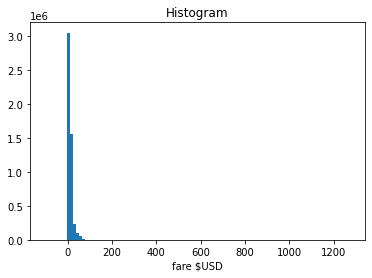

In [14]:
#Fare Amount

plt.hist(df['fare_amount'], bins=100)
plt.xlabel('fare $USD')
plt.title('Histogram');

plt.show()

In [15]:
#Remove Data which are above $200 and less than $0

df.drop(df[(df.fare_amount < 0)|(df.fare_amount > 200)].index, inplace=True)

## Removing Outlier From Passeger Count

In [16]:
# Passenger Count
df['passenger_count'].value_counts()

1      3458762
2       738292
5       353891
3       219251
4       106005
6       105773
0        17602
208          7
9            2
129          1
51           1
7            1
Name: passenger_count, dtype: int64

In [17]:
#Remove Passenger Data which are above 10 and 0
df.drop(df[(df.passenger_count > 10)|(df.passenger_count == 0)].index, inplace=True)

In [18]:
df['passenger_count'].value_counts()

1    3458762
2     738292
5     353891
3     219251
4     106005
6     105773
9          2
7          1
Name: passenger_count, dtype: int64

## Removing coordinates which are outside New Work

New York Boundary 

Get minimum and maximum Latitude and Longitude of New York?: https://gis.stackexchange.com/questions/255158/get-minimum-and-maximum-latitude-and-longitude-of-new-york

* WEST LONGITUDE -74.257159
* EAST LONGITUDE -73.699215
* NORTH LATITUDE 40.915568
* SOUTH LATITUDE 40.495992

In [34]:
from IPython.display import IFrame

IFrame('https://upload.wikimedia.org/wikipedia/commons/b/bc/FedStats_Lat_long.png', 500, 500)

In [37]:
df.drop(df[(df.pickup_longitude < -74.15)|(df.pickup_longitude > -73.7004)].index, inplace=True)
df.drop(df[(df.dropoff_longitude < -74.15)|(df.dropoff_longitude > -73.7004)].index, inplace=True)

df.drop(df[(df.pickup_latitude < 40.5774)|(df.pickup_latitude > 40.9176)].index, inplace=True)
df.drop(df[(df.dropoff_latitude < 40.5774)|(df.dropoff_latitude > 40.9176)].index, inplace=True)

## Visualizing Pickup Coordinates

In [52]:
import folium

map =folium.Map(location=[40.8176, -74.0004], zoom_start = 11,tiles = "Stamen Toner")

sample = df.sample(n = 500)

for i,j in sample.iterrows():
    folium.Marker([j["pickup_latitude"], j["pickup_longitude"]]).add_to(map)

map

# Feature Engineering

In [50]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844315,40.721317,-73.841614,40.712276,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016045,40.711304,-73.979271,40.782005,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982735,40.761269,-73.991241,40.750561,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987129,40.733143,-73.991570,40.758091,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968094,40.768009,-73.956657,40.783764,1


## Time of the Day

In [46]:
# Converting Pickup DateTimes to bins of 10 minutes

data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'],format='%d-%m-%Y %H:%M')

In [58]:
from datetime import datetime
datetime.fromtimestamp(df['pickup_datetime'][0])

TypeError: ignored

In [60]:
type(df['pickup_datetime'][0])

str

## Day of the Week

In [53]:
import datetime as dt
df['pickup_datetime'].dt.day

AttributeError: ignored

In [54]:
df['pickup_datetime'].dtypes

dtype('O')

## Location Clustering

## Traveled Distance

## Public Holiday

## Weather